In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from datetime import datetime

In [2]:
class Config:
    DATA_PATH = r"/kaggle/input/tabular-dataset-ready-for-malicious-url-detection/train_dataset.csv"
    BATCH_SIZE = 1024
    NUM_EPOCHS = 100
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.01
    PATIENCE = 50
    TEST_SIZE = 0.15
    VAL_SIZE = 0.15
    USE_CLASS_WEIGHTS = False
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Config()

In [3]:
df = pd.read_csv(config.DATA_PATH)
display(df.head())

,url,label,source,url_has_login,url_has_client,url_has_server,url_has_admin,url_has_ip,url_isshorted,url_len,...,pdomain_count_hyphen,pdomain_count_atrate,pdomain_count_non_alphanum,pdomain_count_digit,tld_len,tld,tld_is_sus,pdomain_min_distance,subdomain_len,subdomain_count_dot
0,irs-profilepaymentservice.com/home,1,phishtank,0,0,0,0,0,0,34,...,0,0,0,0,3,com,0,17,0,0
1,cpuggsukabumi.id,0,majestic_million,0,0,0,0,0,0,16,...,0,0,0,0,2,id,1,10,0,0
2,members.tripod.com/~don_rc/ring.htm,0,data_clean_test_mendel,0,0,0,0,0,0,35,...,0,0,0,0,3,com,0,2,7,0
3,optuswebmailadminprovider.weebly.com/,1,phishtank,0,0,0,1,0,0,37,...,0,0,0,0,3,com,0,3,25,0
4,topoz.com.pl,0,dmoz_harvard,0,0,0,0,0,0,12,...,0,0,0,0,6,com.pl,0,3,0,0


In [4]:
df.columns

Index(['url', 'label', 'source', 'url_has_login', 'url_has_client',
       'url_has_server', 'url_has_admin', 'url_has_ip', 'url_isshorted',
       'url_len', 'url_entropy', 'url_hamming_1', 'url_hamming_00',
       'url_hamming_10', 'url_hamming_01', 'url_hamming_11', 'url_2bentropy',
       'url_3bentropy', 'url_count_dot', 'url_count_https', 'url_count_http',
       'url_count_perc', 'url_count_hyphen', 'url_count_www',
       'url_count_atrate', 'url_count_hash', 'url_count_semicolon',
       'url_count_underscore', 'url_count_ques', 'url_count_equal',
       'url_count_amp', 'url_count_letter', 'url_count_digit',
       'url_count_sensitive_financial_words', 'url_count_sensitive_words',
       'url_nunique_chars_ratio', 'path_len', 'path_count_no_of_dir',
       'path_count_no_of_embed', 'path_count_zero', 'path_count_pertwent',
       'path_has_any_sensitive_words', 'path_count_lower', 'path_count_upper',
       'path_count_nonascii', 'path_has_singlechardir', 'path_has_upperdir'

In [5]:
df['label'].value_counts()

label
0    5283175
1    1445673
Name: count, dtype: int64

In [6]:
X = df.drop(columns=['label', 'url', 'source', 'tld'])
y = df['label']

In [7]:
X.columns

Index(['url_has_login', 'url_has_client', 'url_has_server', 'url_has_admin',
       'url_has_ip', 'url_isshorted', 'url_len', 'url_entropy',
       'url_hamming_1', 'url_hamming_00', 'url_hamming_10', 'url_hamming_01',
       'url_hamming_11', 'url_2bentropy', 'url_3bentropy', 'url_count_dot',
       'url_count_https', 'url_count_http', 'url_count_perc',
       'url_count_hyphen', 'url_count_www', 'url_count_atrate',
       'url_count_hash', 'url_count_semicolon', 'url_count_underscore',
       'url_count_ques', 'url_count_equal', 'url_count_amp',
       'url_count_letter', 'url_count_digit',
       'url_count_sensitive_financial_words', 'url_count_sensitive_words',
       'url_nunique_chars_ratio', 'path_len', 'path_count_no_of_dir',
       'path_count_no_of_embed', 'path_count_zero', 'path_count_pertwent',
       'path_has_any_sensitive_words', 'path_count_lower', 'path_count_upper',
       'path_count_nonascii', 'path_has_singlechardir', 'path_has_upperdir',
       'query_len', 'que

In [8]:
if config.USE_CLASS_WEIGHTS:
    X_balanced = X
    y_balanced = y

    class_weights = compute_class_weight('balanced', classes=np.unique(y_balanced), y=y_balanced)
    print(f"\nComputed class weights: {class_weights}")
else:
    df_combined = pd.concat([X, y.rename('target')], axis=1)

    classes = np.unique(y)
    class_dfs = [df_combined[df_combined.target == c] for c in classes]

    min_samples = min(len(df) for df in class_dfs)
    print(f"\nOriginal class sizes: {[len(df) for df in class_dfs]}")

    downsampled_dfs = [
        resample(df, replace=False, n_samples=min_samples, random_state=42)
        for df in class_dfs
    ]

    df_balanced = pd.concat(downsampled_dfs)

    X_balanced = df_balanced.drop(columns=['target'])
    y_balanced = df_balanced['target'].values

    print(f"\nBalanced class distribution: {np.bincount(y_balanced)}")


Original class sizes: [5283175, 1445673]

Balanced class distribution: [1445673 1445673]


In [9]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=config.TEST_SIZE,
    random_state=42,
    stratify=y_balanced
)

val_size_adjusted = config.VAL_SIZE / (1 - config.TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size_adjusted,
    random_state=42,
    stratify=y_temp
)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [11]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Handle both numpy arrays and pandas Series
y_train_tensor = torch.tensor(y_train if isinstance(y_train, np.ndarray) else y_train.values, dtype=torch.int64)
y_val_tensor = torch.tensor(y_val if isinstance(y_val, np.ndarray) else y_val.values, dtype=torch.int64)
y_test_tensor = torch.tensor(y_test if isinstance(y_test, np.ndarray) else y_test.values, dtype=torch.int64)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

In [12]:
class MaliciousURLDetector(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128, 64], dropout_rate=0.3, use_batch_norm=True):
        super(MaliciousURLDetector, self).__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm

        layers = []
        prev_dim = input_dim

        self.feature_attention = nn.Sequential(
            nn.Linear(input_dim, input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4, input_dim),
            nn.Sigmoid()
        )

        for i, hidden_dim in enumerate(hidden_dims):
            # Main path
            layer_block = []
            layer_block.append(nn.Linear(prev_dim, hidden_dim))

            if use_batch_norm:
                layer_block.append(nn.BatchNorm1d(hidden_dim))

            layer_block.append(nn.ReLU())
            layer_block.append(nn.Dropout(dropout_rate))

            setattr(self, f'layer_{i}', nn.Sequential(*layer_block))

            if prev_dim == hidden_dim:
                setattr(self, f'residual_{i}', nn.Identity())
            else:
                setattr(self, f'residual_{i}', nn.Linear(prev_dim, hidden_dim))

            prev_dim = hidden_dim

        self.output_layer = nn.Linear(hidden_dims[-1], 2)

        self._initialize_weights()

    def _initialize_weights(self):
        """weights using Xavier/Glorot"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # attention
        attention_weights = self.feature_attention(x)
        x = x * attention_weights

        for i in range(len(self.hidden_dims)):
            layer = getattr(self, f'layer_{i}')
            residual = getattr(self, f'residual_{i}')

            identity = residual(x)
            out = layer(x)
            x = out + identity  # Residual

        x = self.output_layer(x)
        return x

In [13]:
device = torch.device(config.DEVICE)
device

device(type='cuda')

In [14]:
model = MaliciousURLDetector(input_dim=X_train_tensor.shape[1]).to(device)

In [15]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            total_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [16]:
input_size = X_train_scaled.shape[1]
num_classes = len(np.unique(y_balanced))

model = MaliciousURLDetector(input_dim=X_train_tensor.shape[1]).to(config.DEVICE)

if config.USE_CLASS_WEIGHTS:
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [17]:
best_val_loss = float('inf')
best_val_acc = 0
patience_counter = 0

train_losses = []
train_accs = []
val_losses = []
val_accs = []

start_time = datetime.now()

for epoch in range(config.NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, config.DEVICE)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
        }, 'best_model.pth')
    else:
        patience_counter += 1

    if epoch % 5 == 0:
        print(f'Epoch [{epoch+1}/{config.NUM_EPOCHS}]')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f} | Patience: {patience_counter}/{config.PATIENCE}')

    if patience_counter >= config.PATIENCE:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

Epoch [1/100]
  Train Loss: 0.3217 | Train Acc: 0.8702
  Val Loss:   0.2906 | Val Acc:   0.8827
  LR: 0.001000 | Patience: 0/50
Epoch [6/100]
  Train Loss: 0.2745 | Train Acc: 0.8908
  Val Loss:   0.2692 | Val Acc:   0.8928
  LR: 0.001000 | Patience: 0/50
Epoch [11/100]
  Train Loss: 0.2680 | Train Acc: 0.8937
  Val Loss:   0.2620 | Val Acc:   0.8960
  LR: 0.001000 | Patience: 0/50
Epoch [16/100]
  Train Loss: 0.2645 | Train Acc: 0.8953
  Val Loss:   0.2590 | Val Acc:   0.8975
  LR: 0.001000 | Patience: 0/50
Epoch [21/100]
  Train Loss: 0.2616 | Train Acc: 0.8966
  Val Loss:   0.2624 | Val Acc:   0.8976
  LR: 0.001000 | Patience: 3/50
Epoch [26/100]
  Train Loss: 0.2601 | Train Acc: 0.8973
  Val Loss:   0.2565 | Val Acc:   0.8990
  LR: 0.001000 | Patience: 0/50
Epoch [31/100]
  Train Loss: 0.2584 | Train Acc: 0.8982
  Val Loss:   0.2550 | Val Acc:   0.8993
  LR: 0.001000 | Patience: 1/50
Epoch [36/100]
  Train Loss: 0.2567 | Train Acc: 0.8989
  Val Loss:   0.2516 | Val Acc:   0.9011
  

In [18]:
training_time = datetime.now() - start_time
print(f"\nTraining completed in {training_time}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_acc:.4f}")

checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']+1}")


Training completed in 0:58:54.418269
Best validation loss: 0.2471
Best validation accuracy: 0.9033

Loaded best model from epoch 91


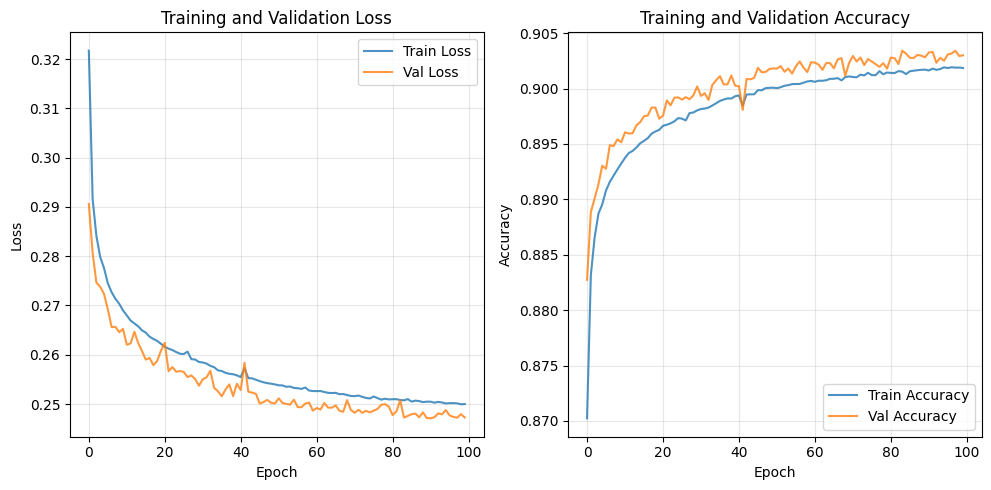

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Val Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy', alpha=0.8)
plt.plot(val_accs, label='Val Accuracy', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
test_loss, test_acc = validate(model, test_loader, criterion, config.DEVICE)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Get predictions for detailed metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(config.DEVICE)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


Test Loss: 0.2471
Test Accuracy: 0.9028


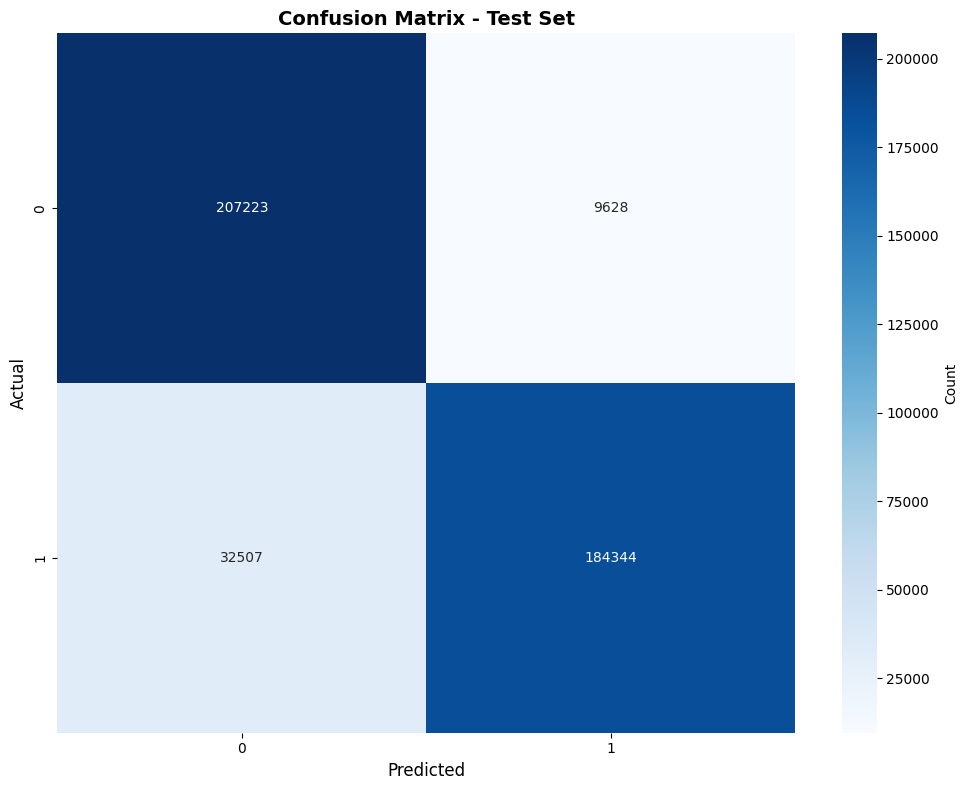

In [21]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_balanced),
            yticklabels=np.unique(y_balanced),
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
def save_complete_model(model, scaler, config, feature_names, tld_encoder=None, save_dir='./model_artifacts'):
    import os
    os.makedirs(save_dir, exist_ok=True)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    model_path = f'{save_dir}/model_{timestamp}.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_dim': model.input_dim,
        'hidden_dims': model.hidden_dims,
        'dropout_rate': model.dropout_rate,
        'use_batch_norm': model.use_batch_norm,
    }, model_path)
    print(f"✓ Model saved to: {model_path}")

    scaler_path = f'{save_dir}/scaler_{timestamp}.pkl'
    joblib.dump(scaler, scaler_path)
    print(f"✓ Scaler saved to: {scaler_path}")

    feature_path = f'{save_dir}/features_{timestamp}.pkl'
    with open(feature_path, 'wb') as f:
        pickle.dump(feature_names, f)
    print(f"✓ Features saved to: {feature_path}")

    config_path = f'{save_dir}/config_{timestamp}.pkl'
    config_dict = {
        'BATCH_SIZE': config.BATCH_SIZE,
        'DEVICE': config.DEVICE,
        'USE_CLASS_WEIGHTS': config.USE_CLASS_WEIGHTS,
    }
    with open(config_path, 'wb') as f:
        pickle.dump(config_dict, f)
    print(f"✓ Config saved to: {config_path}")

    # Save TLD encoder if provided
    tld_path = None
    if tld_encoder is not None:
        try:
            tld_path = f"{save_dir}/tld_encoder_{timestamp}.pkl"
            joblib.dump(tld_encoder, tld_path)
            print(f"✓ TLD encoder saved to: {tld_path}")
        except Exception as e:
            print(f"⚠ Could not save TLD encoder: {e}")

    return model_path, scaler_path, feature_path, config_path, tld_path

In [23]:
feature_names = X.columns.tolist()

model_path, scaler_path, feature_path, config_path, tld_path = save_complete_model(model, scaler, config, feature_names)
print('\nSaved artifacts:')
print('  model_path:', model_path)
print('  scaler_path:', scaler_path)
print('  feature_path:', feature_path)
print('  config_path:', config_path)

✓ Model saved to: ./model_artifacts/model_20251022_170830.pth
✓ Scaler saved to: ./model_artifacts/scaler_20251022_170830.pkl
✓ Features saved to: ./model_artifacts/features_20251022_170830.pkl
✓ Config saved to: ./model_artifacts/config_20251022_170830.pkl

Saved artifacts:
  model_path: ./model_artifacts/model_20251022_170830.pth
  scaler_path: ./model_artifacts/scaler_20251022_170830.pkl
  feature_path: ./model_artifacts/features_20251022_170830.pkl
  config_path: ./model_artifacts/config_20251022_170830.pkl


In [30]:
def load_model_for_prediction(model_path, scaler_path, feature_path, config_path):
    checkpoint = torch.load(model_path, map_location='cpu')

    model = MaliciousURLDetector(
        input_dim=checkpoint['input_dim'],
        hidden_dims=checkpoint['hidden_dims'],
        dropout_rate=checkpoint['dropout_rate'],
        use_batch_norm=checkpoint['use_batch_norm']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    scaler = joblib.load(scaler_path)

    with open(feature_path, 'rb') as f:
        feature_names = pickle.load(f)

    with open(config_path, 'rb') as f:
        config_dict = pickle.load(f)

    print("Model loaded successfully!")
    return model, scaler, feature_names, config_dict

In [31]:
model, scaler, feature_names, config_dict = load_model_for_prediction(r"/kaggle/working/model_artifacts/model_20251022_170830.pth", 
                                                                     r"/kaggle/working/model_artifacts/scaler_20251022_170830.pkl",
                                                                     r"/kaggle/working/model_artifacts/features_20251022_170830.pkl",
                                                                     r"/kaggle/working/model_artifacts/config_20251022_170830.pkl")

def predict_urls(model, scaler, feature_names, new_data, device='cpu'):
    model.to(device)
    model.eval()

    if isinstance(new_data, pd.DataFrame):
        new_data = new_data[feature_names]

    X_scaled = scaler.transform(new_data)

    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        outputs = model(X_tensor)
        probabilities = F.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)

    return predictions.cpu().numpy(), probabilities.cpu().numpy()

Model loaded successfully!


In [32]:
predictions, probabilities = predict_urls(
    model, scaler, feature_names, X_test, device=config.DEVICE
)

print(f"Predictions shape: {predictions.shape}")
print(f"First 10 predictions: {predictions[:10]}")
print(f"Probability of malicious (class 1): {probabilities[:10, 1]}")

Predictions shape: (433702,)
First 10 predictions: [1 0 1 0 1 1 1 1 0 0]
Probability of malicious (class 1): [0.7729455  0.07690141 0.9578044  0.16206503 0.9999901  1.
 0.99994564 0.9998024  0.4697353  0.35624415]


In [35]:
single_sample = X_test.iloc[[2]]
pred, prob = predict_urls(model, scaler, feature_names, single_sample, device=config.DEVICE)
print(f"Prediction: {'Malicious' if pred[0] == 1 else 'Benign'}")
print(f"Confidence: {prob[0][pred[0]]:.4f}")
print(f"Malicious probability: {prob[0][1]:.4f}")

Prediction: Malicious
Confidence: 0.9578
Malicious probability: 0.9578
